In [1]:
from dask.distributed import Client, progress
client = Client(dashboard_address=':5555')  # set up local cluster on your laptop
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:5555/status,
Dashboard: http://127.0.0.1:5555/status,Workers: 4
Total threads: 12,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58219,Workers: 4
Dashboard: http://127.0.0.1:5555/status,Total threads: 12
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:58230,Total threads: 3
Dashboard: http://127.0.0.1:58233/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:58222,


In [2]:
import fsspec
fs = fsspec.filesystem('gs')
fs.ls('gs://gcp-public-data-arco-era5/ar')

['gcp-public-data-arco-era5/ar/1959-2022-1h-240x121_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-1h-360x181_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-128x64_equiangular_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-128x64_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-1440x721.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-240x121_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-512x256_equiangular_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-64x32_equiangular_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-64x32_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2',
 'gcp-public-data-arco-era5/ar/1959-2022-full_37-6h-0p25deg-chunk-1.zarr-v2',
 'gcp-public-data-arco-era5/ar/1959-2022-full_37-6h-0p25deg_der

We will select `1959-2022-full_37-6h-0p25deg-chunk-1.zarr-v2`, and then aggregate to daily in our box.

# Problem 1

In [4]:
import xarray as xr

#Beautiful Champaign-Urbana, IL
lon_cent = 360-88.0
lat_cent = 40.0
delta = 5.0/2.0
delta_big = 40.0/2.0

ds = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-6h-0p25deg_derived.zarr",
    chunks={'time': '100MB'},
    consolidated=True,
)

In [5]:
ds

<xarray.Dataset>
Dimensions:                                           (time: 92044,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 37)
Coordinates:
  * latitude                                          (latitude) float32 90.0...
  * level                                             (level) int64 1 2 ... 1000
  * longitude                                         (longitude) float32 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/34)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    10m_wind_speed                                    (time, latitude, longitude) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    type_of_low_vegetation                            (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    u_component_of_wind                               (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    v_component_of_wind                               (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    vertical_velocity                                 (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    wind_speed                                        (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>

In [6]:
tp = ds['total_precipitation_6hr'].sel(longitude=slice(lon_cent-delta,lon_cent+delta),
                                              latitude=slice(lat_cent+delta,lat_cent-delta),
                                              time=slice('2010-01-01 12:00','2020-12-31 12:00')).resample(
                                              time="1D").sum()
box_ds = tp.mean(dim=['longitude','latitude']).compute()

In [7]:
#save just in case
box_ds.to_netcdf('Champaign_precipitation_time_series.nc')

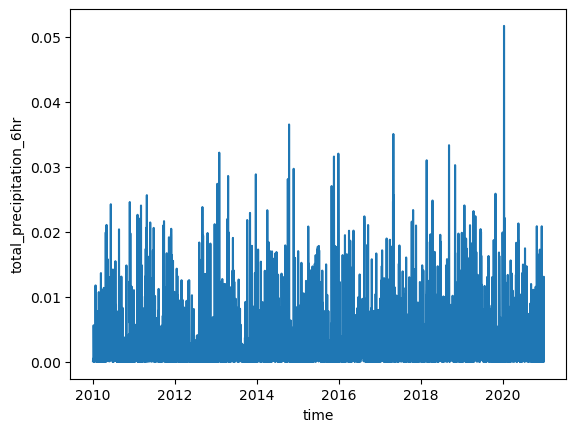

In [8]:
box_ds.plot()

In [13]:
monthly_climatology = box_ds.groupby(
        'time.month').sum(dim='time')

Text(0.5, 1.0, 'Monthly Climatology of Precipitation in Champaign, IL')

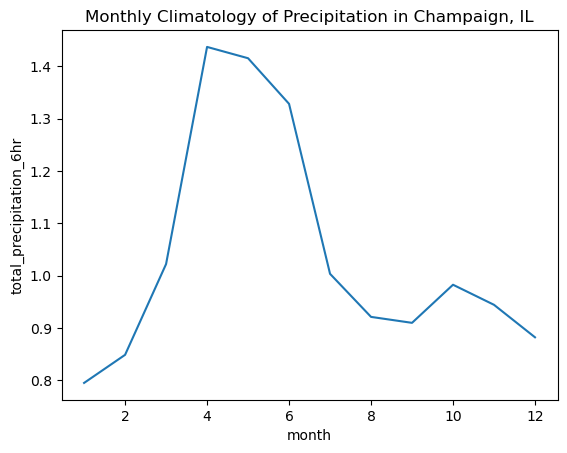

In [19]:
import matplotlib.pyplot as plt
monthly_climatology['total_precipitation_6hr'].plot()
plt.title('Monthly Climatology of Precipitation in Champaign, IL')

In [46]:
# Select only the hourly data in the three wettest months as identified above, convert to mm/day
cmi_daily_wet_months = box_ds['total_precipitation_6hr'][(box_ds['time'].dt.month >= 4) & (box_ds['time'].dt.month <= 6)]*1000.

In [47]:
import numpy as np
# Drop any nan values and create a histogram of the data
no_nan = cmi_daily_wet_months.dropna('time')
count, bins_count = np.histogram(no_nan, bins=20)

In [48]:
# Select only the data within the 95th percentile of wet days in these months
cmi_extremes = cmi_daily_wet_months[cmi_daily_wet_months
>= cmi_daily_wet_months.quantile(.95)]

In [49]:
# Compute the probability density function
pdf = count / sum(count)

In [50]:
# Now we can compute the cumulative distribution function as desired
cdf = np.cumsum(pdf)

The 95% value is 16.708860769271833


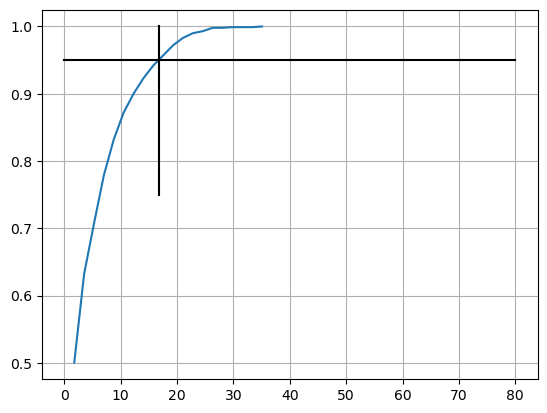

In [51]:
# Find the precip value located at the 95th percentile cut-off
ninetyfive = np.interp(0.95, cdf, bins_count[1:])
# Plot the CDF curve
plt.plot(bins_count[1:], cdf, label="CDF")
# Create a horizontal line at the 9th percentile
x1 = np.linspace(0, 80, num=20)
y1 = np.linspace(0.95, 0.95, num=20)
plt.plot(x1, y1, 'k')
# Create a vertical line at the precip value which occurs at the 95th 
# percentile cutoff
x2 = np.linspace(ninetyfive,ninetyfive, num=20)
y2 = np.linspace(0.75, 1, num=20)
plt.plot(x2, y2, 'k')
# Add gridlines
plt.grid()
# And print the precip value which occurs at the 95th percentile cutoff
print(f'The 95% value is {ninetyfive}')

# Problem 3

In [52]:
#get the big box data
big_box_ds = ds['total_precipitation_6hr'].sel(longitude=slice(lon_cent-delta_big,lon_cent+delta_big),
                                              latitude=slice(lat_cent+delta_big,lat_cent-delta_big),
                                              time=slice('2010-01-01 12:00','2020-12-31 12:00')).resample(
                                              time="1D").sum().compute()
big_box_ds.to_netcdf('Big_box_precipitation_data.nc')

In [12]:
box_ds = xr.open_dataset('Champaign_precipitation_time_series.nc')
big_box_ds = xr.open_dataset('Big_box_precipitation_data.nc')

In [61]:
# Select data in a 40x40 grid around this city on days where extreme precip 
# occurred and convert to mm
extreme_days_precip=big_box_ds.sel(time=cmi_extremes.time).mean(dim='time').compute()*1000.

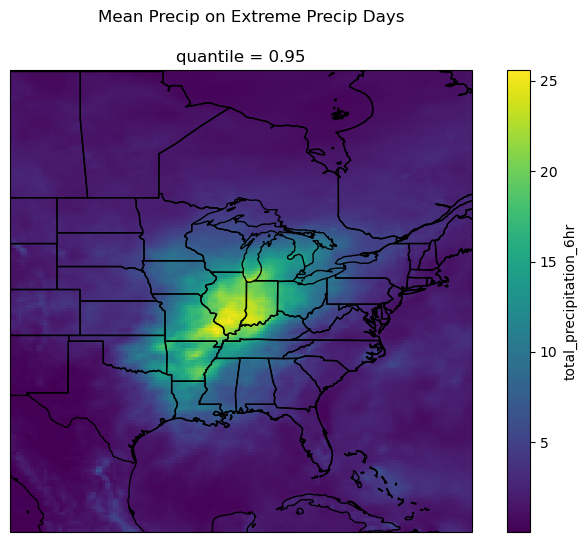

In [63]:
# Plot the mean precip data
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.suptitle('Mean Precip on Extreme Precip Days')
ax.add_feature(cfeature.STATES)
extreme_days_precip.plot(ax=ax, transform=ccrs.PlateCarree())

In [62]:
extreme_days_precip

<xarray.DataArray 'total_precipitation_6hr' (latitude: 161, longitude: 161)>
array([[1.2533718 , 1.1607441 , 1.0911264 , ..., 1.012386  , 1.0487263 ,
        1.0731603 ],
       [1.3460329 , 1.2428437 , 1.1655736 , ..., 1.086083  , 1.1295196 ,
        1.1426682 ],
       [1.3258888 , 1.208718  , 1.1190478 , ..., 1.1269966 , 1.1810257 ,
        1.191035  ],
       ...,
       [0.0418448 , 0.03775348, 0.03254143, ..., 1.8174163 , 1.6153849 ,
        1.4091315 ],
       [0.03756287, 0.04158297, 0.03496955, ..., 2.0394168 , 1.8366041 ,
        1.5949297 ],
       [0.03550202, 0.04235155, 0.03890558, ..., 2.3534393 , 2.056415  ,
        1.8310153 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float32 252.0 252.2 252.5 252.8 ... 291.5 291.8 292.0
    quantile   float64 0.95